In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy as sc
import cmath as cm

In [2]:
file = r"C:\Users\zacwa\OneDrive\Documents\Georgia Tech\CDA, CSE-ISYE6740\homework\hw 4\marriage.csv"
# # # this data regarding divorce, divorce (1/0) is in the final column
# # # the features do not have labels which is fine since no analysis is needed here
data = pd.read_csv(file,sep=',',header=None)
m, n = data.shape
X = data.iloc[:,0:(n-1)].copy()
y = data.iloc[:,(n-1)].copy()

print(f'dims of data: {X.shape}')

dims of data: (170, 54)


#### Quick Dim Reduction with PCA
The dimensionality is high so I'll preform a quick PCA to get the eigenvectors accounting for 90% or more of variance. Just for fun, I'll use sklearn to quickly get the number of components that comprise 90% or more of the variance. I'll then implement PCA a bit more manually [just for even more fun] with the chosen number of componenets.

28
0.8995627952381109


(28, 54)

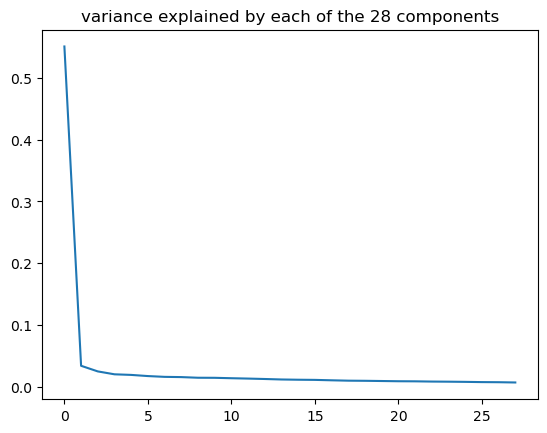

In [3]:
NoComps = np.linspace(2,40,39).astype(int)

for nc in NoComps:
    pca = PCA(n_components=nc).fit(X)
    if np.sum(pca.explained_variance_ratio_) >= 0.899:
        plt.plot(pca.explained_variance_ratio_)
        plt.title(f'variance explained by each of the {nc} components')
        comps = nc
        print(nc)
        print(np.sum(pca.explained_variance_ratio_))
        break

PCA(n_components=comps).fit(X).components_.shape

Here's a quick (slightly more manual) implementation of PCA using the optimal number of components chosen above. These eigenvectors will be used in the optimization algorithms.

In [4]:
xmu = X-np.mean(X,axis=0)
C = np.dot(xmu.T,xmu)/m

evl, evc = np.linalg.eig(C)
# remove imaginary elements
evl = evl.real
evc = evc.real
# get the index that sorts eigenvalues high to low
idx_sort = np.argsort(evl)[::-1]
# sort and take the first K components that result in 90% of variance
evl = evl[idx_sort][:comps]
evc = evc[:,idx_sort][:,:comps]
# project to reduce dimensions with normalization using eigenvectors
Z = np.array((evc.T@xmu.T).T/np.sqrt(evl))

In [5]:
Z.shape

(170, 28)

## Optimization

First, I'll implement basic Gradient Descent. It is a straightforward implementation. \
\
Least Squares Regression is a very common objective function for illustrations of convex, unconstrained optimization. \
\
Given the loss function $f(x) = \frac{1}{n}\sum(y-X\beta)^2 $ our objective function is
$ \; f(x)=\frac{1}{2}||y-X\beta||_{2}^{2} $. But this problem does have a convenient closed form solution: \
$ \;\;\;\;\frac{df}{d\beta} = -X^{T}(y-X\beta) $\
$ \;\;\;\;0 = -X^{T}y+X^{T}X\beta $\
$ \;\;\;\;X^{T}X\beta = X^{T}y $ \
$ \;\;\;\;\beta = (X^{T}X)^{-1}X^{T}y $\
\
A basic gradient descent given the gradient \
$ \;\;\;\;\nabla_{x}f(x) = -X^{T}(y-X\beta) $\
will result in the pseudocode

#### initialize $\delta,\beta,\mu$
#### while $||\nabla_{x}f(x)||_{2} >= \delta $
$ \;\;\;\; \beta = \beta - \mu(\nabla_{x}f(x)) $
\
\
But given that there is a convenient closed form solution, it just isn't very interesting to use this function as the example objective function to illustrate optimization. Logisitcs regression, however, does not have a closed form solution. Maximum Likelihood and optimization are used to solve it.

### Logistic Regression Function

The logistic regression problem can be expressed as $ p(y|X) = \frac{1}{1+e^{-\mu}} $\
where $ \mu = \beta_{0}+\beta_{1}x_{1}+...+\beta_{n}x_{n} $. \
and the output $y$ is a Bernouli random variable.\
\
The parameters $\beta$ are taken from the likelihood of the function written in terms of the Bernoulli random variable\
$\;\;\;\; L(\beta;y,X)=\prod^{N}_{i}p(y_{i}|x_{i})^{y_{i}}(1-p(y_{i}|x_{i}))^{1-y_{i}} $ \
which is easier to solve in terms of log-likelihood\
$\;\;\;\; l(\beta;y,X)=\sum^{N}_{i}(-ln(1+exp(x_{i}\beta))+y_{i}x_{i}\beta) = (-ln(1+exp(X\beta))+y^{T}X\beta) $\
\
So, the MLE form of the problem is \
$\;\;\;\; argmax_{\beta}\sum_{n}^{i}logp(y_{i}|x_{i},\beta)$\
\
Next I'll need the gradient and Hessian \
$\;\;\;\; \nabla_{\beta}l(\beta;y,X)=\sum^{N}_{i}(y_{i}-p(y_{i}|x_{i}))x_{i} = X^{T}(y-\hat{y}) $\
$\;\;\;\; \nabla_{\beta\beta}l(\beta;y,X)=-\sum_{i}^{N}x^{T}_{i}x_{i}p(y_{i}|x_{i})(1-p(y_{i}|x_{i})) = -X^{T}WX $\
where W is an $NxN$ diagonal matrix $i=1...N$ with each $x_{i}$ on the diagnoal 

Details on maths:\
https://www.statlect.com/fundamentals-of-statistics/logistic-model-maximum-likelihood \
ESL, Hastie, Tibshirani, Friedman

In [6]:
# # # needed functions
def logfunc(Z,B):
    ZB = np.exp(-Z@B)
    return ZB/(1+ZB)

def log_l(y,Z,B):
    ZB = np.exp(Z@B)
    ll = np.sum( -np.log(1+ZB) + y.T@Z@B )
    return ll

def grad(Z,B):
    return Z.T@(y - logfunc(Z,B)) # y - yhat

def Hess(Z,B):
    W = np.diag(logfunc(Z,B)*(1-logfunc(Z,B)))
    return -Z.T@W@Z

### Gradient Descent

With backtracking lin search....\
Backtracking line search reduces the step size so that the parameter estimation doesn't overshoot the min/max.

In [7]:
# initializations
m, n = Z.shape
tolerance = 1e-3
B = np.zeros(n)
G0 = grad(Z,B)
H = Hess(Z,B)
u = 0.01
i = 1
e = 10
L, error, gradL = [log_l(y,Z,B)], [], [np.linalg.norm(G0)]
while e > tolerance:

    B = B - u*grad(Z,B)
    
    G = grad(Z,B)
    u = u/2**(i-1) # backtracking line search
    i += 1
    e = np.linalg.norm(G-G0)
    
    L.append(log_l(y,Z,B))
    error.append(e)
    gradL.append(np.linalg.norm(G))
    G0 = G

Text(0.5, 1.0, 'error over iterations, final error 0.0002037334843105824')

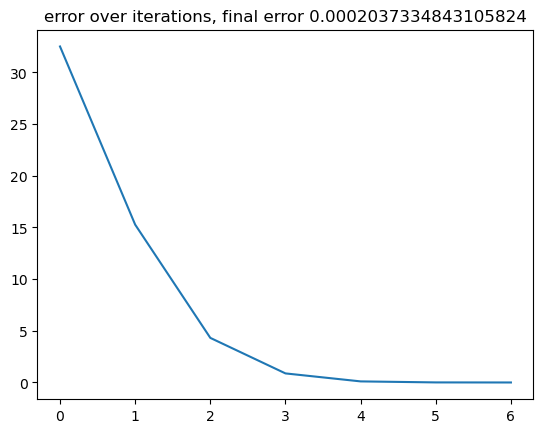

In [8]:
plt.figure()
plt.plot(error)
plt.title(f'error over iterations, final error {error[-1]}')

Text(0.5, 1.0, 'likelihood fuction over iterations')

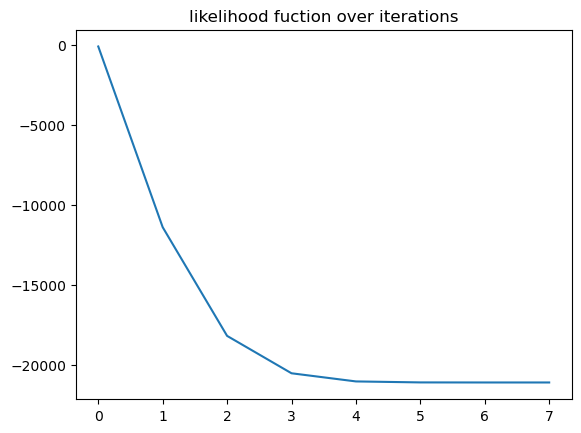

In [9]:
plt.figure()
plt.plot(L)
plt.title('likelihood fuction over iterations')

Text(0.5, 1.0, 'gradient over iterations, last value 28.30850050286732')

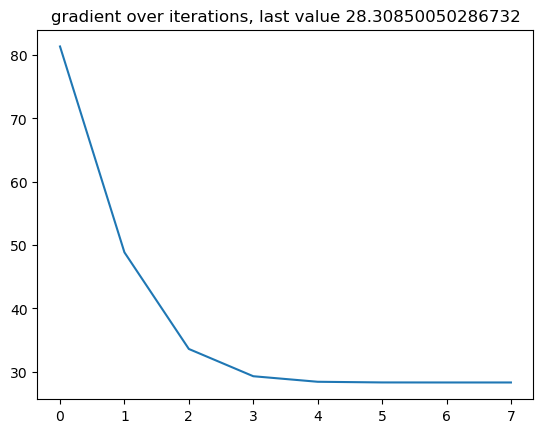

In [10]:
plt.figure()
plt.plot(gradL)
plt.title(f'gradient over iterations, last value {gradL[-1]}')

Here's a quick check on the accuracy of the $\beta$ estimates that were optimized. Of course, it would be more proper to evaluate on a test set.

In [11]:
np.mean(np.where(logfunc(Z,B)>=0.6,1,0)==y)

0.9764705882352941

### Accelerated Gradient Descent
AGD usually converges significantly faster. In this instance it converges in just one fewer iterations. 

In [12]:
# initializations
m, n = Z.shape
tolerance = 1e-3
B2 = np.zeros(n)
B20 = B2
G0 = grad(Z,B2)
H = Hess(Z,B2)
u = 0.01
i = 1
e = 10
L, error, gradL = [log_l(y,Z,B2)], [], [np.linalg.norm(G0)]
while e > tolerance:

    C = B2 - u*grad(Z,B2)
    B2 = C + (i-1)/(i+2)*(B2-B20)
    B20 = B2
    
    G = grad(Z,B2-min(B2))
    u = u/2**(i-1) # B2acktracking line search
    i += 1
    e = np.linalg.norm(G-G0)
    
    L.append(log_l(y,Z,B2))
    error.append(e)
    gradL.append(np.linalg.norm(G))
    G0 = G

Text(0.5, 1.0, 'error over iterations, final error 0.00018688960613264874')

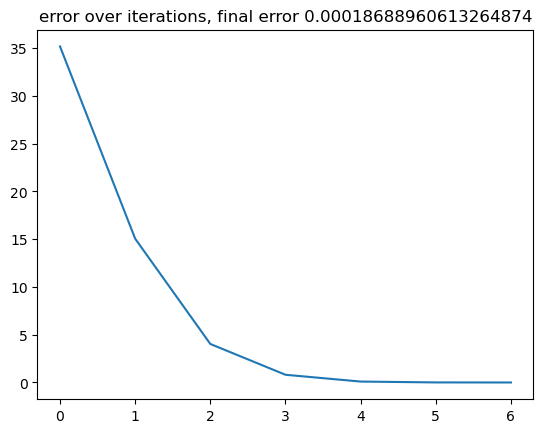

In [13]:
plt.figure()
plt.plot(error)
plt.title(f'error over iterations, final error {error[-1]}')

Text(0.5, 1.0, 'likelihood fuction over iterations')

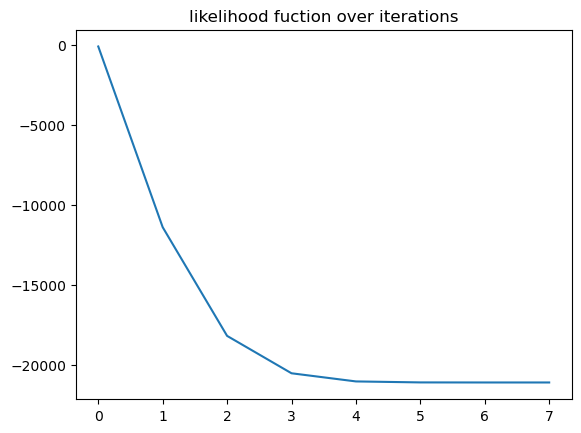

In [14]:
plt.figure()
plt.plot(L)
plt.title('likelihood fuction over iterations')

Text(0.5, 1.0, 'gradient over iterations, last value 30.811641463630806')

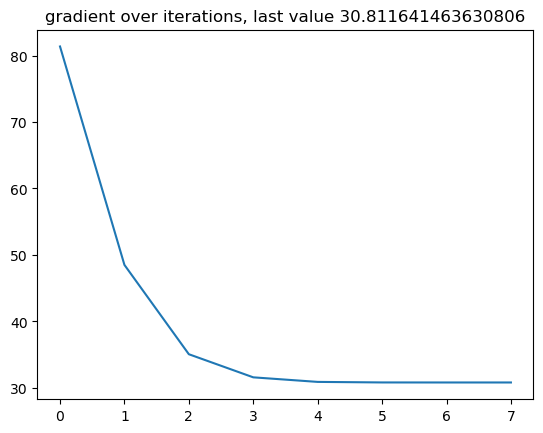

In [15]:
plt.figure()
plt.plot(gradL)
plt.title(f'gradient over iterations, last value {gradL[-1]}')

In [16]:
np.mean(np.where(logfunc(Z,B2)>=0.6,1,0)==y)

0.9764705882352941

### Newton's Method

In [17]:
# initializations
m, n = Z.shape
tolerance = 1e-3
lam = 1e-10
B3 = np.zeros(n)
G0 = grad(Z,B3)
H = Hess(Z,B3)
# lam makes the paraB3ola more steep around the current B3
O = np.linalg.solve(H + lam*np.eye(n),-G0)
u = 0.01
i = 1
e = 10
L, error, gradL = [log_l(y,Z,B3)], [], [np.linalg.norm(G0)]
while e > tolerance:
    
    B3 = B3 - u*O
    
    G = grad(Z,B3)
    O = np.linalg.solve(Hess(Z,B3) + lam*np.eye(n),-G)
    u = u/2**(i-1) # B3acktracking line search
    i += 1
    e = np.linalg.norm(G-G0)
    
    L.append(log_l(y,Z,B3))
    error.append(e)
    gradL.append(np.linalg.norm(G))
    G0 = G

Text(0.5, 1.0, 'error over iterations, final error 0.000773833259019356')

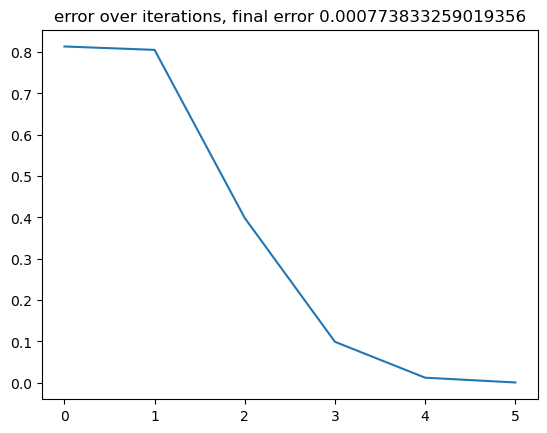

In [18]:
plt.figure()
plt.plot(error)
plt.title(f'error over iterations, final error {error[-1]}')

Text(0.5, 1.0, 'likelihood fuction over iterations')

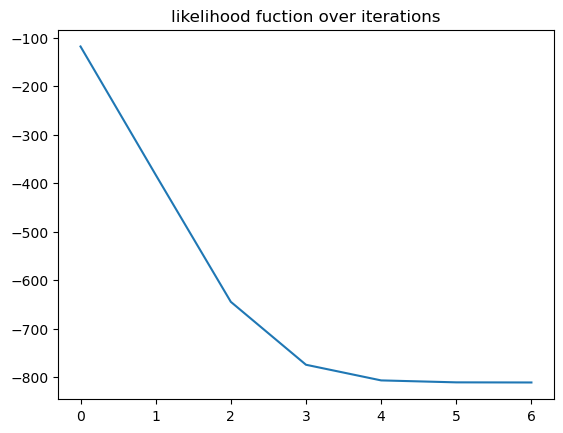

In [19]:
plt.figure()
plt.plot(L)
plt.title('likelihood fuction over iterations')

Text(0.5, 1.0, 'gradient over iterations, last value 79.23977318943801')

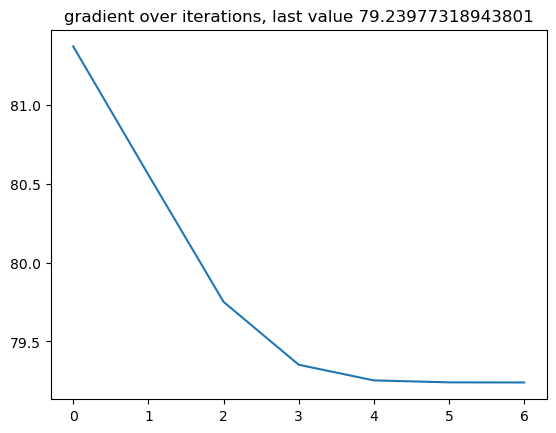

In [20]:
plt.figure()
plt.plot(gradL)
plt.title(f'gradient over iterations, last value {gradL[-1]}')

In [21]:
np.mean(np.where(logfunc(Z,B3)>=0.6,1,0)==y)

0.5058823529411764